# Programming Assignment: Building a Robust Data Pipeline

Welcome to the assignment for Data Management in PyTorch.

In earlier examples, you've worked with clean, pre-packaged datasets. In reality, data is rarely that simple. In computer vision, images often come in different sizes and formats and must be preprocessed before a model can learn from them. Manually handling this for thousands of images would be both tedious and error-prone.

In this assignment, you’ll work with the [Plants Classification](https://www.kaggle.com/datasets/marquis03/plants-classification) dataset, which contains 30,000 `.jpg` images across 30 plant species such as aloe vera, banana, spinach, and watermelon. Like many real-world datasets, the images vary in size and quality and are organized into folders by class. For this exercise, you’ll use a subset of 3,000 images.

This is where a data pipeline comes in. You’ll get hands-on experience building a custom dataset, applying the necessary transformations, and loading your data in batches. These are the essential first steps before training a deep learning model.

**What You will do in this Assignment**

* Access and explore the structure of an image dataset.
* Build a custom `Dataset` class to load your images and labels on demand.
* Define a series of `transformations`, including resizing, tensor conversion, and `normalization`, to preprocess the data.
* Define augmentation transforms to enhance the training dataset.
* Split the dataset into training, validation, and test sets applying the appropriate transforms to each and creating `DataLoader` instances for efficient batching.

Let's get started!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.
---

## Table of Contents
- [Imports](#imports)
- [1 - Data Access](#1---data-access)
    - [1.1 - Exploring the Dataset](#11---exploring-the-dataset)
    - [1.2 - Creating a Custom Dataset Class](#12---creating-a-custom-dataset-class)
        - **[Exercise 1 - PlantsDataset](#exercise-1---plantsdataset)**
    - [1.3 - Overview of the images in the dataset](#13---overview-of-the-images-in-the-dataset)
- [2 - Transformations](#2---transformations)
    - [2.1 - Computing Mean and Standard Deviation](#21---computing-mean-and-standard-deviation)
    - [2.2 - Defining Transformations](#22---defining-transformations)
        - **[Exercise 2 - get_transformations](#exercise-2---get_transformations)**
- [3 - Data Loading](#3---data-loading)
    - **[Exercise 3 - get_data_loaders](#exercise-3---get_data_loaders)**

<a name='imports'></a>
## Imports

In [6]:
pip install directory-tree fastai

   ---------------------------------------- 0.0/14.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.2 MB ? eta -:--:--
    --------------------------------------- 0.3/14.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.2 MB 1.2 MB/s eta 0:00:12
   -- ------------------------------------- 0.8/14.2 MB 907.1 kB/s eta 0:00:15
   -- ------------------------------------- 0.8/14.2 MB 907.1 kB/s eta 0:00:15
   -- ------------------------------------- 1.0/14.2 MB 839.3 kB/s eta 0:00:16
   --- ------------------------------------ 1.3/14.2 MB 919.8 kB/s eta 0:00:15
   ---- ----------------------------------- 1.6/14.2 MB 953.2 kB/s eta 0:00:14
   ----- ---------------------------------- 1.8/14.2 MB 1.0 MB/s eta 0:00:13
   ----- ---------------------------------- 2.1/14.2 MB 1.0 MB/s eta 0:00:12
   ------ --------------------------------- 2.4/14.2 MB 1.1 MB/s eta 0:00:11
   ------- -------------------------------- 2.6/14.2 MB 1.1 MB/s eta 0:00:11
   -------


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

In [2]:
from tqdm.auto import tqdm
import helper_utils
import unittests

c:\Users\w\Documents\my_csv_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'dlai_grader'

<a name='1---data-access'></a>
## 1 - Data Access 

<a name='11---exploring-the-dataset'></a>
### 1.1 - Exploring the Dataset

As you’ve already learned, the first step when working with any new dataset is to explore it. This involves understanding its structure, the types of data it contains, and identifying any potential issues such as missing values or outliers.

In this step, you’ll use the `print_data_folder_structure` function from `helper_utils` to print the dataset's folder layout. 
This will help you see how the files and directories are organized, a crucial step before you start loading and preprocessing the data.

In [5]:
path_dataset = './plants_dataset'

helper_utils.print_data_folder_structure(path_dataset, max_depth=1)

plants_dataset/
├── test.csv
├── train.csv
├── val.csv
├── test/
├── train/
└── val/


You now have an initial understanding of the dataset structure:
- `df_labels.csv`,
- `classname.txt`,
- One folder per class, each containing the images for that class (all in `.jpg` format).

This information will be useful when you design your custom Dataset class later on.

In [7]:
# print the content of `df_labels.csv`
df_labels = pd.read_csv(f'{path_dataset}/val.csv')
print(df_labels.head())

                     image:FILE  category
0  val/aloevera/aloevera700.jpg         0
1  val/aloevera/aloevera701.jpg         0
2  val/aloevera/aloevera702.jpg         0
3  val/aloevera/aloevera703.jpg         0
4  val/aloevera/aloevera704.jpg         0


In [10]:
# print the content of `classname.txt`

with open(f'{path_dataset}/val/classname.txt', 'r') as f:
    class_names = f.read().splitlines()
print(class_names)

['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peperchili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweetpotatoes', 'tobacco', 'waterapple', 'watermelon']


You’ve verified that `df_labels.csv` contains the labels for each image along with their corresponding file names, and that `classname.txt` contains the names of all the classes.

<a name='12---creating-a-custom-dataset-class'></a>
### 1.2 - Creating a Custom Dataset Class

It is now time to create a custom dataset class to handle the plant images dataset. 
This class will inherit from `torch.utils.data.Dataset` and will be responsible for loading and preprocessing the images along with their corresponding labels.

<a name='exercise-1---plantsdataset'></a>
#### **Exercise 1 - `PlantsDataset`**

**Your Task:**

Your task is to complete the implementation of the custom PyTorch Dataset class `PlantsDataset`. 
You need to implement the missing code in multiple sections within the class:

* **Complete the `__init__` method**:
    * Load labels from the DataFrame using the already defined `load_labels` method on the `.df_info` attribute.
    * Create a mapping from label integers to class names using the already defined `read_classname` method.

* **Complete the `__len__` method**:
    * Return the total number of samples in the dataset by extracting the length of the `.labels` attribute.

* **Complete the `__getitem__` method**:
    * Retrieve the image at the specified index using the existing `retrieve_image` method.
    * Apply transformations to the image if they are specified.
    * Get the corresponding label from the `.labels` attribute.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
If you need a little help, here's a more detailed guide for each method:

**For the `__init__` method:**
* For `self.labels`: Call `self.load_labels()` to extract labels from the `self.df_info` DataFrame.

**For the `__len__` method:**
* Use the built-in `len()` function on `self.labels`.

**For the `__getitem__` method:**
* Use `self.retrieve_image(idx)` to get the image at the specified index.
* If `self.transform` is not None, apply it to the image using `self.transform(image)`.
* Get the label from `self.labels[idx]`.

</details>

In [22]:
# GRADED CLASS: PlantsDataset
class PlantsDataset(Dataset):
    """
    ExDataset is a custom PyTorch Dataset for loading images and their corresponding labels from a specified directory and CSV file.

    Args:
        root_dir (str): Root directory containing the dataset files, including 'classname.txt'.
        transform (callable, optional): Optional transform to be applied on a sample.

    Attributes:
        root_dir (str): Path to the root directory of the dataset.
        transform (callable): Transformations to apply to the images.
        df_info (pd.DataFrame): DataFrame containing image file names and category labels.
        labels (list): List of integer labels for each image.
        class_names (list): List of class names corresponding to label indices.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.

        Args:
            root_dir (str): Path to the root directory containing the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        # Initialize path to root directory and transformations
        self.root_dir = root_dir
        self.transform = transform

        # Read the CSV file (with images path and category labels)
        self.df_info = self.read_df()

        ### START CODE HERE ###

        # Load labels from the DataFrame using the `load_labels` method
        self.labels =self.load_labels(self.df_info)

        # Create a mapping from label integers to class names using the `read_classname` method
        self.class_names = self.read_classname()

        ### END CODE HERE ###

    def read_df(self):
        """
        Reads a CSV file from the specified path and returns it as a pandas DataFrame.
        """
        
        path_csv = self.root_dir + "/train.csv"
       # path_csv = self.root_dir + "/df_labels.csv"
        df = pd.read_csv(path_csv)
        return df

    def read_classname(self):
        """
        Reads class names from a file named 'classname.txt' located in the root directory.

        Returns:
            list: A list of class names, each as a string, read from the file.
        """
        path_txt = self.root_dir + "/classname.txt"
        with open(path_txt, "r") as f:
            class_names = f.read().splitlines()
        return class_names

    def load_labels(self, df):
        """
        Extracts label integers from a DataFrame and returns them as a list.
        """
        labels = []

        for idx, row in df.iterrows():
            label_int = row["category"]
            labels.append(label_int)
        return labels

    def get_label_description(self, label: int):
        """
        Returns the description of a class label.
        """
        description = self.class_names[label]
        return description

    def retrieve_image(self, idx: int):
        """
        Retrieves and returns from the folder the PIL image at the specified index.
        It converts the image to RGB mode.
        """
        from PIL import Image
        img_path = self.root_dir + "/" + self.df_info.iloc[idx]["image:FILE"]
        with Image.open(img_path) as img:
            image = img.convert("RGB")
        return image

    ### START CODE HERE ###

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        # Return the total number of samples from the `.labels` attribute
        length =len(self.labels)
        return length

    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding label at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple (image, label) where:
                - image: The image at the given index, possibly transformed if a transform is specified.
                - label: The label corresponding to the image.
        """
        # Retrieve the image using the `retrieve_image` method
        image =self.retrieve_image(idx)

        # Apply the specified transformations to the image, if any
        # The None of the if condition is not part of the exercise, leave it as is
        if self.transform is not None:
            image = self.transform(image)

        # Retrieve the label from the `labels` attribute
        label = self.labels[idx]

        # Return the image and label
        return image,label

    ### END CODE HERE ###

In [23]:



plants_dataset = PlantsDataset(root_dir=path_dataset, transform=None)

In [24]:
# print the length of the dataset
print(f'Length of the dataset: {len(plants_dataset)}')

Length of the dataset: 21000


Description: aloevera
Image shape: (1280, 720)



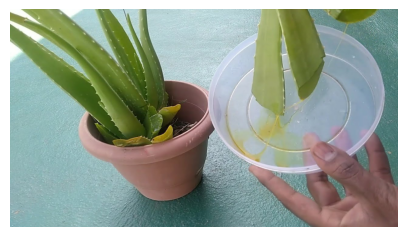

In [25]:
# Look at a sample to check it's working correctly
sel_idx = 10
img, label = plants_dataset[sel_idx]

# Visualize the image
helper_utils.plot_img(img)

# Print its description
print(f'Description: {plants_dataset.get_label_description(label)}')

# Print its shape
print(f'Image shape: {img.size}\n')  # PIL image size is (width, height)

##### **Expected Output**
```
Description: aloevera
Image shape: (269, 187)
```

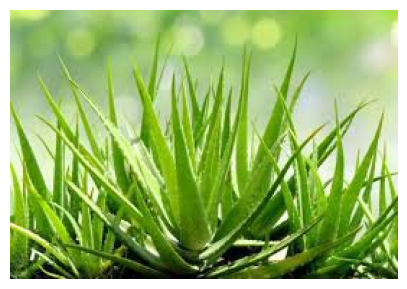

In [26]:
from IPython.display import Image
Image('exp_out_1.png')

In [ ]:
# Test your code!
unittests.exercise_1(PlantsDataset)

<a name='13---overview-of-the-images-in-the-dataset'></a>
### 1.3 - Overview of the images in the dataset

The images are now accessible through the custom dataset class you implemented in the previous exercise. However, they haven’t been preprocessed yet, a necessary step before feeding them into a neural network.

In this step, you’ll explore the dataset using the `visual_exploration` function from `helper_utils`.
This function displays a few sample images along with their labels, allowing you to visually inspect the data and get a sense of its main characteristics.

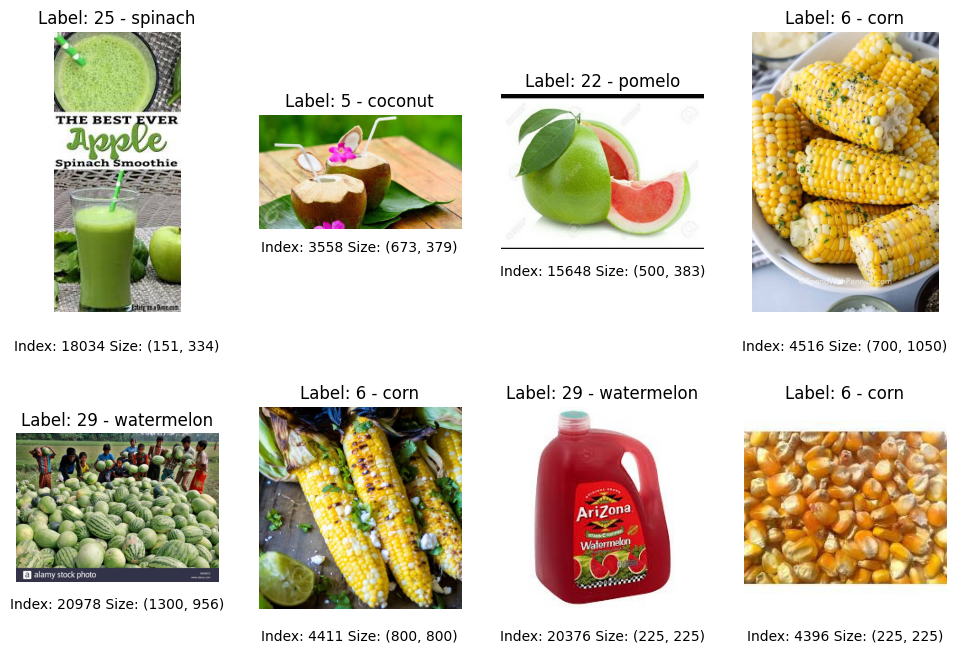

In [27]:
helper_utils.visual_exploration(plants_dataset, num_rows=2, num_cols=4)

From the visual exploration, you can see that the images in the dataset vary in size, color, and background.
This kind of variability is common in real-world datasets and underscores the importance of preprocessing steps such as resizing, normalization, and data augmentation to help the model generalize effectively across different types of images.

<a name='2---transformations'></a>
## 2 - Transformations

Before feeding images into a neural network, you need to preprocess them using a series of transformations.
These steps include resizing the images to a consistent size, converting them into tensors, and normalizing their pixel values.

<a name='21---computing-mean-and-standard-deviation'></a>

### 2.1 - Computing Mean and Standard Deviation

Below is an auxiliary function `get_mean_std` that computes the mean and standard deviation of the training dataset.
These statistics are required for the normalization step in the preprocessing pipeline.

Since resizing and converting images to tensors changes the pixel value distribution, the mean and standard deviation must be computed after these transformations are applied.

In `get_mean_std`, you will:

* **Preprocessing Setup**:
A transform pipeline resizes images to 128×128 and converts them to tensors.

* **First Pass — Compute Mean**:
For each image, the pixels are flattened, and the channel-wise pixel values are summed globally across the entire dataset.
Dividing by the total number of pixels yields the channel-wise mean.

* **Second Pass — Compute Standard Deviation**:
With the mean known, we compute the squared difference between each pixel and its channel mean, accumulate across the dataset, and then take the square root to obtain the channel-wise standard deviation.

**Note**:
The mean and standard deviation should usually be computed only on the training set.
Using statistics computed from the test or validation data can introduce data leakage, where information from the evaluation set influences the training process.
In this case, since at this point the data has not yet been split, you will compute the statistics on the entire dataset for simplicity.
The mean and standard deviation values you obtain here will not change much when computed solely on the training set.

In [28]:
def get_mean_std(dataset: Dataset):
    # Define the resizing and tensor conversion pipeline
    preprocess = transforms.Compose(
        [transforms.Resize((128, 128)), transforms.ToTensor()]
    )
    
    # Pass 1: Mean Calculation
    total_pixels = 0
    sum_pixels = torch.zeros(3)
    
    # [Visual] Wrap dataset in tqdm to create the progress bar iterator
    mean_loader = tqdm(dataset, desc="Pass 1/2: Computing Mean")
    
    for img, _ in mean_loader:
        # Core computation for mean
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1) # [channels, pixels]
        sum_pixels += pixels.sum(dim=1)
        total_pixels += pixels.size(1)
    
    mean = sum_pixels / total_pixels
    
    # Pass 2: Standard Deviation Calculation
    sum_squared_diff = torch.zeros(3)
    
    # [Visual] Wrap dataset in tqdm to create the progress bar iterator
    std_loader = tqdm(dataset, desc="Pass 2/2: Computing Std")
    
    for img, _ in std_loader:
        # Core computation for std
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1) # [channels, pixels]
        diff = pixels - mean.unsqueeze(1)
        sum_squared_diff += (diff ** 2).sum(dim=1)
    
    std = torch.sqrt(sum_squared_diff / total_pixels)
    
    return mean, std

In [29]:
# Define the transformations to make to the images
mean, std = get_mean_std(plants_dataset)

print(f"\nMean: {mean}")
print(f" Std: {std}")

Pass 2/2: Computing Std: 100%|██████████| 21000/21000 [06:02<00:00, 57.87it/s]



Mean: tensor([0.6511, 0.6167, 0.4756])
 Std: tensor([0.2929, 0.2870, 0.3412])


<br>
<details>
<summary><b>The Core Algorithm (Without Progress Bar)</b></summary>
<br>
The function implementation above utilizes <code>tqdm</code> to provide a visual indicator of the iteration speed and estimated time remaining.

It is important to understand that wrapping the dataset in `tqdm(dataset)` does not change the data or the mathematics. The iterator yields the exact same images in the exact same order. 

If you strip away the UI logic to focus strictly on the <b>Mathematical Algorithm</b>, the implementation looks like this:

```python
def get_mean_std(dataset: Dataset):
    preprocess = transforms.Compose(
        [transforms.Resize((128, 128)), transforms.ToTensor()]
    )
    
    # Pass 1: Mean Calculation
    total_pixels = 0
    sum_pixels = torch.zeros(3)
    
    # Iterate directly over the dataset without the visual wrapper
    for img, _ in dataset:
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)  # [channels, pixels]
        sum_pixels += pixels.sum(dim=1)
        total_pixels += pixels.size(1)
    
    mean = sum_pixels / total_pixels
    
    # Pass 2: Standard Deviation Calculation
    sum_squared_diff = torch.zeros(3)
    
    for img, _ in dataset:
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)  # [channels, pixels]
        diff = pixels - mean.unsqueeze(1)
        sum_squared_diff += (diff ** 2).sum(dim=1)
    
    std = torch.sqrt(sum_squared_diff / total_pixels)
    
    return mean, std

<a name='22---defining-transformations'></a>
### 2.2 - Defining Transformations

Having computed the mean and standard deviation of the dataset, you can now define the transformations to apply to the images.
You’ll create two sets of transformations: one for the training set, which includes data augmentation, and another for the validation and test sets.

<a name='exercise-2---get_transformations'></a>
#### **Exercise 2 - `get_transformations`**

**Your Task:**

Your task is to implement the missing code in the `get_transformations` function to create two image transformation pipelines for PyTorch. 

You will implement the following sections:

* **Define `main_tfs`**:
    * Create a `Resize` transform to resize images to 128x128 pixels.
    * Create a `ToTensor` transform to convert PIL images to PyTorch tensors.
    * Create a `Normalize` transform using the provided mean and standard deviation values.

* **Define `augmentation_tfs`**:
    * Create a `RandomVerticalFlip` transform with 50% probability.
    * Create a `RandomRotation` transform that rotates images by ±15 degrees.

* **Compose Transform Pipelines**:
    * Create `main_transform` by combining the main transforms into a single pipeline using `transforms.Compose`.
    * Create `transform_with_augmentation` by combining both augmentation and main transforms into an augmented pipeline.
    The augmentation transforms should be applied before the main transforms.


<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you need a little help, here's a more detailed guide for each section:

**For `main_tfs`:**
* For `Resize`: Use `transforms.Resize((128, 128))` to resize all images to 128x128 pixels.
* For `ToTensor`: Use `transforms.ToTensor()` to convert PIL images to PyTorch tensors.
* For `Normalize`: Use `transforms.Normalize(mean=mean, std=std)` with the provided mean and std parameters.


**For `augmentation_tfs`:**
* For `RandomVerticalFlip`: Use `transforms.RandomVerticalFlip(p=0.5)` to flip images vertically with 50% probability.
* For `RandomRotation`: Use `transforms.RandomRotation(degrees=15)` to rotate images randomly within ±15 degrees.


**For composing transforms:**
* For `main_transform`: Use `transforms.Compose(main_tfs)` to combine the main transforms list.
* For `transform_with_augmentation`: Use `transforms.Compose(augmentation_tfs + main_tfs)` to combine both lists.

</details>

In [32]:
# GRADED FUNCTION : get_transformations
def get_transformations(mean, std):
    """
    Returns two sets of image transformation pipelines: one with basic preprocessing and another with additional data augmentation.

    Args:
        mean: Sequence of mean values for normalization.
        std: Sequence of standard deviation values for normalization.

    Returns:
        main_transform: Transformation pipeline with resizing, tensor conversion, and normalization.
        transform_with_augmentation: Transformation pipeline including random vertical flip, random rotation, resizing, tensor conversion, and normalization.
    """
    ### START CODE HERE ###
    main_tfs = [  
        # Resize images to 128x128 pixels
        transforms.Resize((128,128)),
        # Convert images to PyTorch tensors
        transforms.ToTensor(),
        # Normalize images using the provided mean and std
        transforms.Normalize(mean,std)
    ]  

    augmentation_tfs = [  
        # Randomly flip the image vertically
        transforms.RandomVerticalFlip(0.5),
        # Randomly rotate the image by ±15 degrees
        transforms.RandomRotation(15)
    ]  

    # Compose the main transformations into a single pipeline
    main_transform = transforms.Compose(main_tfs)

    transform_with_augmentation =transforms.Compose( augmentation_tfs + main_tfs)

    ### END CODE HERE ###
    return main_transform, transform_with_augmentation

In [33]:
# Get the transformations
main_transform, transform_with_augmentation = get_transformations(mean, std)

# Print the transformations to verify
print(main_transform)
print(transform_with_augmentation)

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)
Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)


##### **Expected Output**

```
Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
```

In [ ]:
# Test your code!
unittests.exercise_2(get_transformations)

You can verify your transformations by applying them to a sample image from the dataset and inspecting the result.

Transformed Image shape: torch.Size([3, 128, 128])



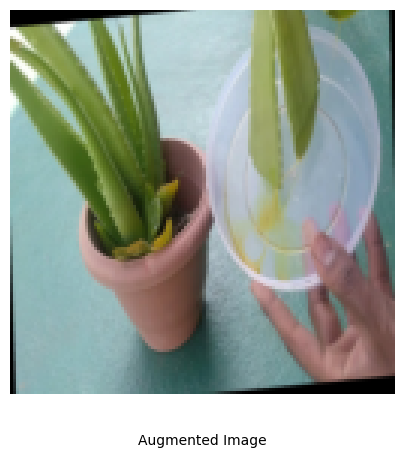

In [34]:
# Check main_transform on a sample image
img_transformed = main_transform(img)
print(f"Transformed Image shape: {img_transformed.shape}\n")


# get denormalization function
denormalize = helper_utils.Denormalize(mean, std)
# visualize the augmented image
img_augmented = transform_with_augmentation(img)
helper_utils.plot_img(denormalize(img_augmented), info=f"Augmented Image")

<a name='3---data-loading'></a>
## 3 - Data Loading

With your custom dataset class and transformations defined, you can now create data loaders to efficiently load and batch data for training and evaluation. This is the final step before you would train a neural network on this dataset.

As in the previous lab, after using `random_split` to divide the dataset into training, validation, and test sets, you need to ensure that each subset uses the appropriate transformations. 
One way to change the transformations of each subset is by wrapping the subsets in new instances of the custom dataset class `SubsetWithTransform`.

In [35]:
class SubsetWithTransform(Dataset):
    """A subset of a dataset with a specific transform applied."""

    def __init__(self, subset: Subset, transform=None):
        # subset should be a subset WITHOUT transform
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

<a name='exercise-3---get_data_loaders'></a>
#### **Exercise 3 - `get_data_loaders`**

**Your Task:**

Your task is to complete the implementation of the `get_dataloaders` function to split a dataset and create PyTorch DataLoaders for training, validation, and testing. 
You need to implement the missing code in three main sections:

* **Split the Dataset**:
    * Use `random_split` to divide the dataset into training, validation, and test sets based on the calculated sizes.

* **Apply Transforms to Each Split**:
    * Wrap each dataset split with `SubsetWithTransform` to apply appropriate transforms.
    * Use `augmentation_transform` for the training set to include data augmentation.
    * Use `main_transform` for both validation and test sets (no augmentation needed).

* **Create DataLoaders**:
    * Create `DataLoader` objects for each dataset split with the specified batch size.
    * Enable shuffling for the training loader to randomize batch order.
    * Disable shuffling for validation and test loaders to maintain consistent evaluation.

<details>
  <summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
  
If you need a little help, here's a more detailed guide for each section:

**For splitting the dataset:**
* Use `random_split(dataset, [train_size, val_size, test_size])` to split the dataset.

**For applying transforms:**
* Use `SubsetWithTransform(dataset_split, transform=transform_to_apply)` for each split.

**For creating DataLoaders:**
* Use `DataLoader(dataset=dataset_split, batch_size=batch_size, shuffle=shuffle_setting)`.
* For training loader: set `shuffle=True` to randomize the order of batches.
* For validation and test loaders: set `shuffle=False` to maintain consistent order for evaluation.
* All loaders should use the same `batch_size` parameter.

</details>

In [36]:
# GRADED FUNCTION : get_dataloaders
def get_dataloaders(
    dataset,
    batch_size,
    val_fraction,
    test_fraction,
    main_transform,
    augmentation_transform,
):
    """
    Splits a dataset into training, validation, and test sets, applies specified transforms to each split,
    and returns corresponding DataLoader objects.

    Args:
        dataset: The full dataset to be split.
        batch_size: Number of samples per batch to load.
        val_fraction: Fraction of the dataset to use for validation.
        test_fraction: Fraction of the dataset to use for testing.
        main_transform: Transform to apply to validation and test splits.
        augmentation_transform: Transform to apply to the training split.

    Returns:
        train_loader: DataLoader for the training set with augmentation transforms.
        val_loader: DataLoader for the validation set with main transforms.
        test_loader: DataLoader for the test set with main transforms.
    """

    # Calculate the sizes of each split
    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size * test_fraction)
    train_size = total_size - val_size - test_size

    ### START CODE HERE ###

    # Split the dataset into training, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(
           dataset, [train_size,val_size,test_size]
    )

    # Create dataset with the corresponding transforms for each split
    train_dataset =SubsetWithTransform(train_dataset, augmentation_transform)
    val_dataset = SubsetWithTransform(val_dataset, main_transform)
    test_dataset = SubsetWithTransform(test_dataset, main_transform)

    # Create DataLoaders for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader =  DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader =  DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    ### END CODE HERE ###
    return train_loader, val_loader, test_loader

In [37]:
train_loader, val_loader, test_loader = get_dataloaders(
    dataset=plants_dataset,
    batch_size=32,
    val_fraction=0.15,
    test_fraction=0.2,
    main_transform=main_transform,
    augmentation_transform=transform_with_augmentation,
)

In [38]:
print('=== Train Loader ===')
print(f"Number of batches in train_loader: {len(train_loader)}")
train_dataset = train_loader.dataset
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Transforms applied to train_dataset: {train_dataset.transform}")
print(f"train_dataset type: {type(train_dataset)}")

print('\n=== Test Loader ===')
print(f"Number of batches in test_loader: {len(test_loader)}")
test_dataset = test_loader.dataset
print(f"Number of samples in test_dataset: {len(test_dataset)}")
print(f"Transforms applied to test_dataset: {test_dataset.transform}")
print(f"test_dataset type: {type(test_dataset)}")

=== Train Loader ===
Number of batches in train_loader: 427
Number of samples in train_dataset: 13650
Transforms applied to train_dataset: Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)
train_dataset type: <class '__main__.SubsetWithTransform'>

=== Test Loader ===
Number of batches in test_loader: 99
Number of samples in test_dataset: 3150
Transforms applied to test_dataset: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)
test_dataset type: <class '__main__.SubsetWithTransform'>


##### **Expected Output**

```
=== Train Loader ===
Number of batches in train_loader: 61
Number of samples in train_dataset: 1950
Transforms applied to train_dataset: Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
train_dataset type: <class '__main__.SubsetWithTransform'>

=== Test Loader ===
Number of batches in test_loader: 19
Number of samples in test_dataset: 600
Transforms applied to test_dataset: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
test_dataset type: <class '__main__.SubsetWithTransform'>
```

In [ ]:
# Test your code!
unittests.exercise_3(get_dataloaders, plants_dataset)

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. 

---

## Conclusion

Congratulations! You have now built an end-to-end data pipeline in PyTorch. 

In this lab, you learned how to construct a complete pipeline to handle a real-world image dataset. You moved beyond basic data loading to explore the core components that make up a PyTorch data pipeline.

You created a custom **`Dataset`** for **data access**, defined a sequence of **transformations** such as resizing, normalization, and data augmentation to improve training robustness, split the dataset into training, validation, and test sets, and used **`DataLoader`** for efficient for efficient batching and iteration.

With these fundamental components—`Dataset`, `Transforms`, and `DataLoader`—you now have a clean, efficient, and reusable workflow for preparing any image dataset for training a neural network. 